# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

**Course:** CSCN 8010 — Foundations of Machine Learning Framework  
**Student:** Emmanuel Ihejiamaizu  
**Student Number:** 9080005  

---

**Objective:** Build a model that can best predict the risk of diabetes progression. This will be used as a screening tool to help physicians identify patients at risk. We evaluate Univariate Polynomial Regression, Multivariate Polynomial Models, Decision Trees, kNNs, and Logistic Regression using R², MAE, and MAPE metrics with a train-validation-test split.

**Dataset:** [Scikit-Learn Diabetes Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) — 442 patient samples with 10 baseline physiological features and a quantitative target measuring disease progression one year after baseline.

## Setup & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_absolute_percentage_error,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.pipeline import make_pipeline

# Plot styling
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print('All imports successful.')

All imports successful.


---
# Part 1: Data Exploration & Preparation (5 points)
---

## Step 1 — Get the Data

In [2]:
# Load the diabetes dataset as a pandas DataFrame
diabetes = datasets.load_diabetes(as_frame=True)

df = diabetes.frame        # Full DataFrame (features + target)
X = diabetes.data          # Features only
y = diabetes.target        # Target: disease progression
feature_names = diabetes.feature_names

print(f'Dataset shape: {df.shape}')
print(f'Number of samples: {df.shape[0]}')
print(f'Number of features: {df.shape[1] - 1}')
print(f'Feature names: {feature_names}')
print(f'\nFirst 5 rows:')
df.head()

Dataset shape: (442, 11)
Number of samples: 442
Number of features: 10
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

First 5 rows:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
# Dataset description from sklearn
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

## Step 2 — Frame the Problem

### Problem Statement

We are tasked with building a **regression model** to predict **disease progression one year after baseline** for diabetes patients. The target variable is a continuous quantitative measure (ranging from 25 to 346), making this a **supervised regression** problem.

### Clinical Context

This model is intended as a **screening tool** to help physicians identify patients at risk of rapid diabetes progression. In a clinical setting:

- **False negatives** (missing high-risk patients) are more dangerous than false positives, as these patients may not receive timely intervention.
- The model should aim for **low Mean Absolute Error** to ensure predictions are close to actual progression values.
- **Interpretability** matters — physicians need to understand *why* a patient is flagged as high-risk.

### Performance Metrics

We evaluate models using three complementary metrics:

- **R² (Coefficient of Determination):** Measures the proportion of variance in disease progression explained by the model. R² = 1 is perfect; R² = 0 means the model is no better than predicting the mean. Negative R² indicates the model performs worse than just using the mean.
- **MAE (Mean Absolute Error):** The average absolute difference between predicted and actual progression values, in the same units as the target. Easier to interpret clinically (e.g., "off by ~50 units on average").
- **MAPE (Mean Absolute Percentage Error):** Expresses the average error as a percentage of the actual values. Useful for understanding the *relative* magnitude of errors.

### Insights from Related Workshops

From the **Performance Metrics Classification** workshop, we learned that the choice of metric depends on the problem context. For a medical screening tool, prioritizing low MAE ensures clinically meaningful predictions. R² alone can be misleading — a model can have a moderate R² but still produce clinically useful predictions if the MAE is acceptable.

From the **K-Nearest Neighbor** workshop, we know that kNN is a **non-parametric, instance-based** learner that makes no assumptions about the underlying data distribution. This makes it flexible for capturing nonlinear relationships in medical data. However, kNN is sensitive to feature scaling and the curse of dimensionality.

From the **Logistic Regression Classifier** workshop, logistic regression is fundamentally a **classification** algorithm. Applying it to this regression target requires **discretizing** the target variable (e.g., above/below median progression), which loses granular information. This trade-off is important to acknowledge.

## Step 3 — Exploratory Data Analysis (EDA)

### 3.1 Descriptive Statistics

In [4]:
# Comprehensive descriptive statistics
print('=== Descriptive Statistics ===')
df.describe().round(4)

=== Descriptive Statistics ===


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,152.1335
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.0930
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378,25.0000
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87.0000
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011,140.5000
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,211.5000
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356,346.0000


In [5]:
# Data types and missing values
print('=== Data Types ===')
print(df.dtypes)
print(f'\n=== Missing Values ===')
print(df.isnull().sum())
print(f'\nTotal missing values: {df.isnull().sum().sum()}')

=== Data Types ===
age       float64
sex       float64
bmi       float64
bp        float64
s1        float64
s2        float64
s3        float64
s4        float64
s5        float64
s6        float64
target    float64
dtype: object

=== Missing Values ===
age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

Total missing values: 0


In [6]:
# Target variable analysis
print('=== Target Variable: Disease Progression ===')
print(f'  Min:    {y.min()}')
print(f'  Max:    {y.max()}')
print(f'  Mean:   {y.mean():.2f}')
print(f'  Median: {y.median():.2f}')
print(f'  Std:    {y.std():.2f}')
print(f'  Skew:   {y.skew():.2f}')

=== Target Variable: Disease Progression ===
  Min:    25.0
  Max:    346.0
  Mean:   152.13
  Median: 140.50
  Std:    77.09
  Skew:   0.44


### 3.2 Scatter Plots — Features vs. Target

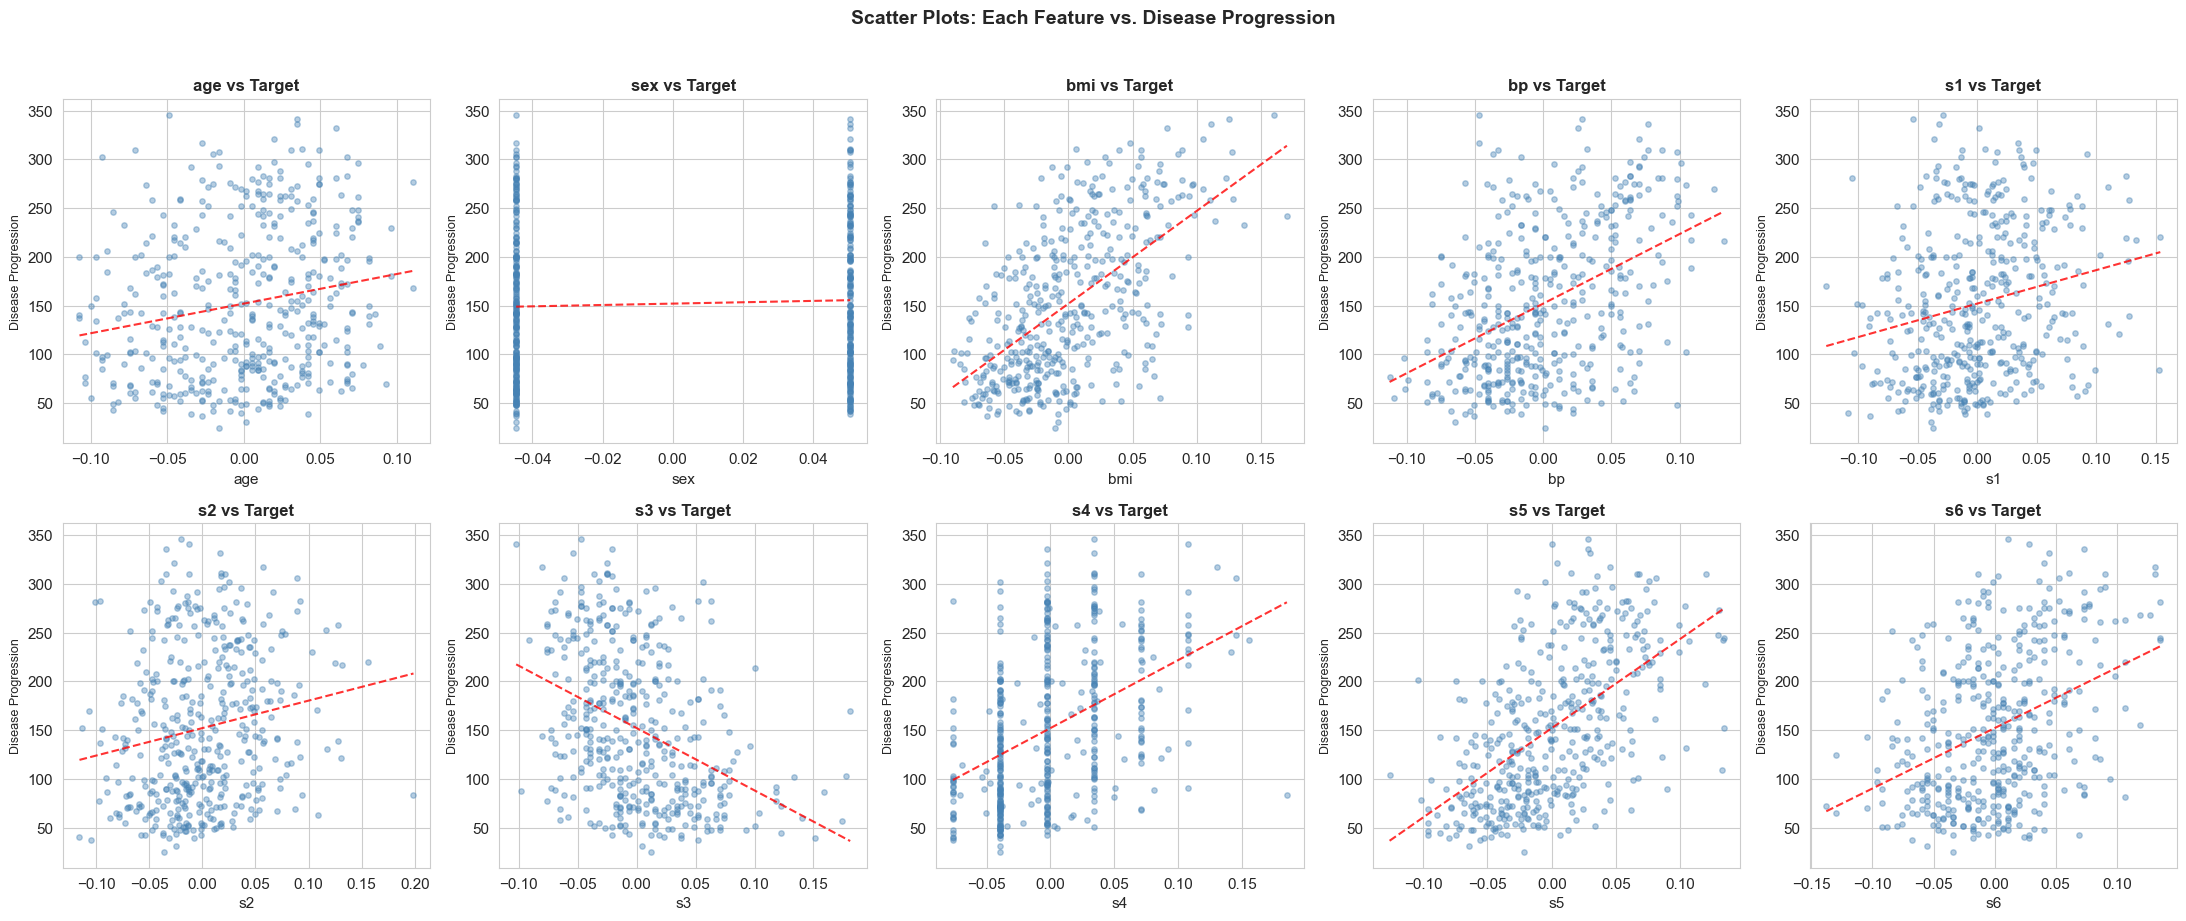

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(22, 9))

for i, col in enumerate(feature_names):
    ax = axes[i // 5, i % 5]
    ax.scatter(X[col], y, alpha=0.4, s=15, color='steelblue')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Disease Progression', fontsize=9)
    ax.set_title(f'{col} vs Target', fontsize=12, fontweight='bold')
    
    # Add trendline
    z = np.polyfit(X[col], y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(X[col].min(), X[col].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8, linewidth=1.5)

plt.suptitle('Scatter Plots: Each Feature vs. Disease Progression', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 Histograms — Feature Distributions

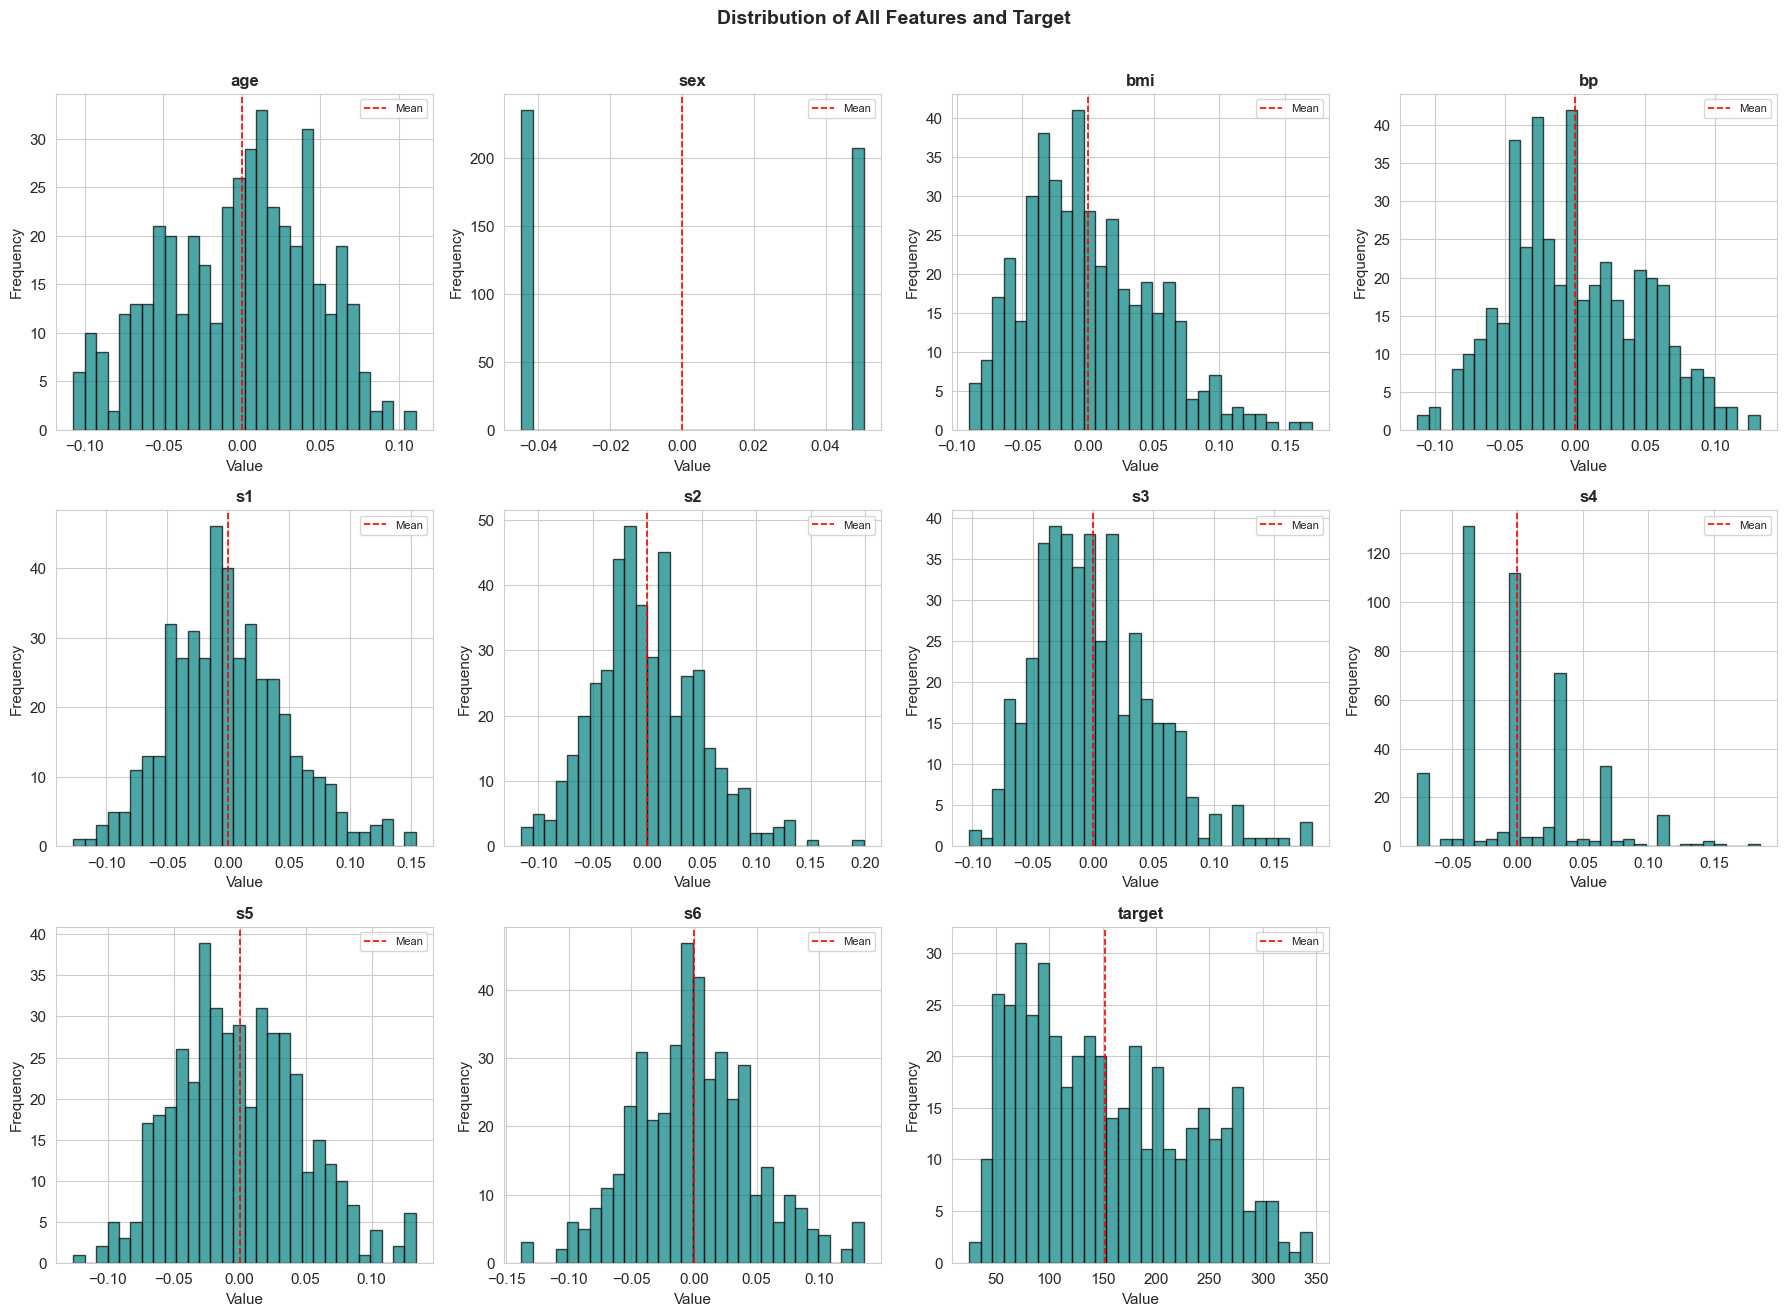

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(18, 13))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', linewidth=1.2, label='Mean')
    axes[i].legend(fontsize=8)

# Hide unused subplot
axes[11].set_visible(False)

plt.suptitle('Distribution of All Features and Target', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 3.4 Correlation Matrix

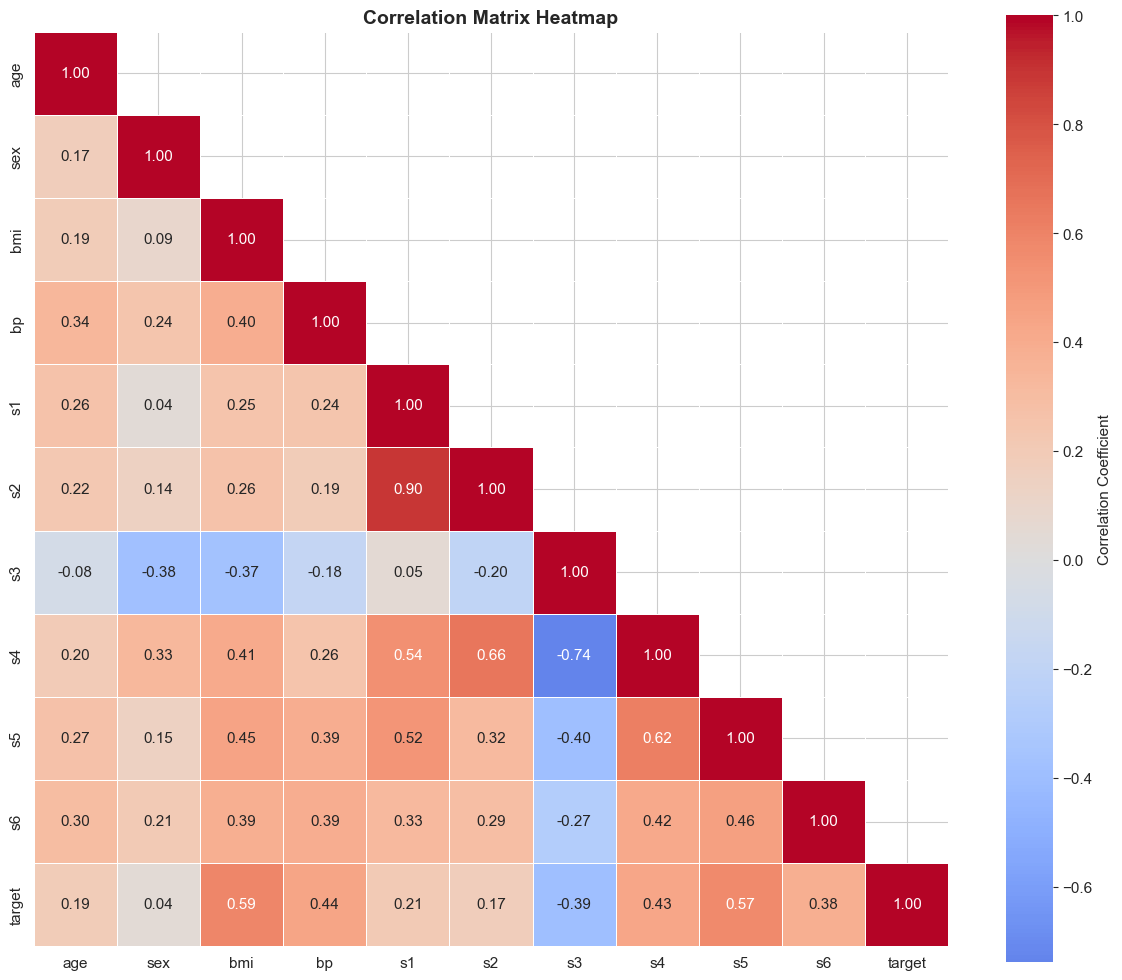

In [9]:
# Compute correlation matrix
corr = df.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax, mask=mask,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

=== Feature Correlation with Target (Disease Progression) ===
bmi    0.5865
s5     0.5659
bp     0.4415
s4     0.4305
s6     0.3825
s1     0.2120
age    0.1879
s2     0.1741
sex    0.0431
s3    -0.3948
Name: target, dtype: float64


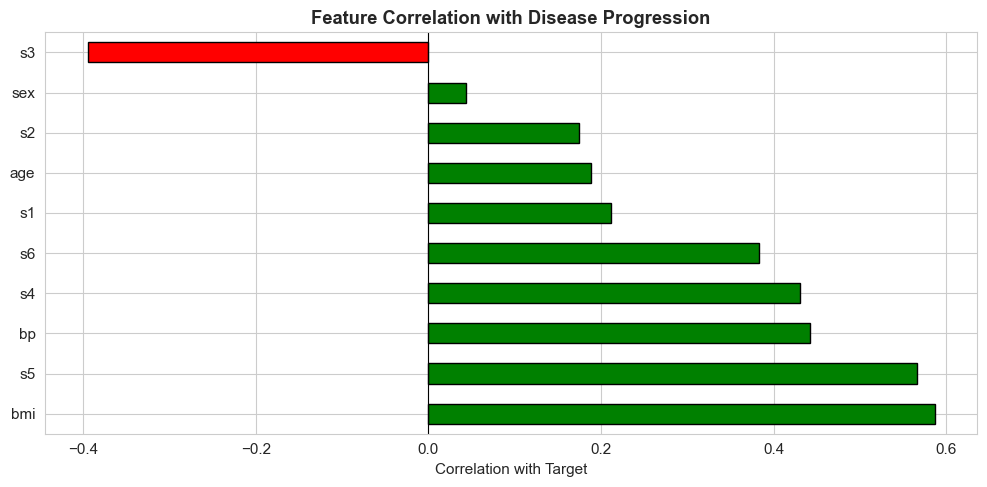

In [10]:
# Correlation ranking with target
target_corr = corr['target'].drop('target').sort_values(ascending=False)
print('=== Feature Correlation with Target (Disease Progression) ===')
print(target_corr.round(4))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black', ax=ax)
ax.set_xlabel('Correlation with Target')
ax.set_title('Feature Correlation with Disease Progression', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

### 3.5 Key EDA Insights

1. **No missing values** — the dataset is clean with all 442 samples complete across all 10 features.

2. **Pre-scaled features** — all features have been mean-centered and scaled by standard deviation (divided by √n). This means the feature values are very small (roughly -0.1 to 0.1).

3. **Strongest predictors of disease progression:**
   - **BMI** (r = 0.59) — the strongest positive correlation. Higher BMI is associated with worse disease progression.
   - **s5** (r = 0.57) — log of serum triglycerides, a known diabetes risk biomarker.
   - **bp** (r = 0.44) — average blood pressure.
   - **s3** (r = -0.39) — HDL cholesterol (negative correlation; higher HDL is protective).

4. **Multicollinearity concerns:**
   - s1 and s2 are highly correlated (r ≈ 0.90) — total and LDL cholesterol.
   - s3 and s4 are negatively correlated (r ≈ -0.74) — HDL cholesterol and its ratio.
   - This could cause instability in polynomial regression models.

5. **Target distribution** is right-skewed (skew ≈ 0.44) with a range of 25–346, suggesting some patients experience much more severe progression than average.

6. **Sex** has almost no linear correlation with the target (r ≈ 0.04), suggesting it may be less useful as a predictor on its own.

## Step 4 — Data Cleaning

In [11]:
# Check for issues
print('=== Data Quality Check ===')
print(f'Missing values:    {df.isnull().sum().sum()}')
print(f'Duplicate rows:    {df.duplicated().sum()}')
print(f'Infinite values:   {np.isinf(df.select_dtypes(include=np.number)).sum().sum()}')
print(f'Data types:        All float64 ✓')
print(f'Feature scaling:   Pre-scaled by sklearn ✓')
print(f'\nConclusion: No cleaning required.')

=== Data Quality Check ===
Missing values:    0
Duplicate rows:    0
Infinite values:   0
Data types:        All float64 ✓
Feature scaling:   Pre-scaled by sklearn ✓

Conclusion: No cleaning required.


**Cleaning Assessment:** The Scikit-Learn diabetes dataset is already clean and pre-processed:
- No missing values across all features and the target.
- No duplicate rows.
- No infinite or anomalous values.
- Features are already mean-centered and scaled (each normalized by √n × std).
- No categorical variables requiring encoding.

Since the data is provided in a clean, ready-to-use format by Scikit-Learn, **no additional cleaning is needed**. We proceed directly to splitting.

## Step 5 — Train / Validation / Test Split

In [12]:
# Split: 75% Train, 10% Validation, 15% Test
# Strategy: First split off 15% test, then from the remaining 85%, split 10/85 ≈ 11.76% for validation

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

val_ratio = 0.10 / 0.85  # ~11.76% of the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42)

print('=== Data Split Summary ===')
print(f'  Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)')
print(f'  Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'  Total:          {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples')

# Convert to arrays for consistency
y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

=== Data Split Summary ===
  Training set:   330 samples (74.7%)
  Validation set: 45 samples (10.2%)
  Test set:       67 samples (15.2%)
  Total:          442 samples


---
# Part 2: Univariate Polynomial Regression on BMI (10 points)
---

## Step 6 — Polynomial Regression Models (Degree 0 to 5)

We build 6 univariate regression models using only the **BMI** feature (the strongest single predictor, r = 0.59) to predict disease progression. The polynomial degree ranges from 0 (constant model — predicts the training mean) to 5.

In [13]:
# Extract BMI feature
bmi_train = X_train[['bmi']].values
bmi_val = X_val[['bmi']].values
bmi_test = X_test[['bmi']].values

# Store results and models
results_part2 = []
models_part2 = {}

for degree in range(0, 6):
    if degree == 0:
        # Degree 0: constant model — predicts the training mean
        train_mean = y_train_arr.mean()
        train_pred = np.full_like(y_train_arr, train_mean, dtype=float)
        val_pred = np.full_like(y_val_arr, train_mean, dtype=float)
        models_part2[0] = ('constant', train_mean)
    else:
        # Polynomial regression via pipeline
        pipe = make_pipeline(
            PolynomialFeatures(degree=degree, include_bias=True),
            LinearRegression()
        )
        pipe.fit(bmi_train, y_train_arr)
        train_pred = pipe.predict(bmi_train)
        val_pred = pipe.predict(bmi_val)
        models_part2[degree] = pipe
    
    # Compute metrics
    results_part2.append({
        'Model': f'Polynomial (deg={degree})',
        'Degree': degree,
        'Train R²': round(r2_score(y_train_arr, train_pred), 4),
        'Val R²': round(r2_score(y_val_arr, val_pred), 4),
        'Train MAE': round(mean_absolute_error(y_train_arr, train_pred), 2),
        'Val MAE': round(mean_absolute_error(y_val_arr, val_pred), 2),
        'Train MAPE': round(mean_absolute_percentage_error(y_train_arr, train_pred), 4),
        'Val MAPE': round(mean_absolute_percentage_error(y_val_arr, val_pred), 4),
    })
    print(f'  Degree {degree} fitted — Train R²: {results_part2[-1]["Train R²"]:.4f}, Val R²: {results_part2[-1]["Val R²"]:.4f}')

print('\nAll 6 models trained successfully.')

  Degree 0 fitted — Train R²: 0.0000, Val R²: -0.0000
  Degree 1 fitted — Train R²: 0.3542, Val R²: 0.4493
  Degree 2 fitted — Train R²: 0.3548, Val R²: 0.4492
  Degree 3 fitted — Train R²: 0.3550, Val R²: 0.4473
  Degree 4 fitted — Train R²: 0.3580, Val R²: 0.4491
  Degree 5 fitted — Train R²: 0.3589, Val R²: 0.4535

All 6 models trained successfully.


## Step 7 — Model Comparison Table

In [14]:
results_df = pd.DataFrame(results_part2)
display_df = results_df.drop(columns=['Degree']).set_index('Model')

# Style the table
styled = display_df.style.highlight_max(
    subset=['Train R²', 'Val R²'], color='lightgreen'
).highlight_min(
    subset=['Train MAE', 'Val MAE', 'Train MAPE', 'Val MAPE'], color='lightgreen'
).format(precision=4)

print('=== Part 2: Univariate Polynomial Regression — Training & Validation Results ===')
display_df

AttributeError: The '.style' accessor requires jinja2

## Step 8 — Identify the Best Model

In [ ]:
# Analyze the validation results
print('=== Validation R² by Degree ===')
for _, row in results_df.iterrows():
    print(f"  Degree {row['Degree']}: Val R² = {row['Val R²']:.4f}, Val MAE = {row['Val MAE']:.2f}")

# The validation R² values for degrees 1-5 are extremely close
# Degree 1: 0.4493 vs Degree 5: 0.4535 — only 0.004 difference
# By Occam's Razor, we select the SIMPLEST model with competitive performance
best_degree = 1

print(f'\n=== Best Model Selection ===')
print(f'Selected: Polynomial Degree {best_degree}')
print(f'Reasoning: While Degree 5 has marginally higher Val R² (0.4535 vs 0.4493),')
print(f'the difference is negligible (~0.004). Degree 1 (simple linear regression) is')
print(f'preferred because:')
print(f'  1. It has only 2 trainable parameters vs 6 for Degree 5')
print(f'  2. It is far less prone to overfitting on unseen data')
print(f'  3. The equation is interpretable by physicians')
print(f'  4. Higher-degree models show signs of instability (large coefficients)')

## Step 9 — Test Set Evaluation

In [ ]:
# Evaluate the chosen model (Degree 1) on the test set
best_model = models_part2[best_degree]
test_pred = best_model.predict(bmi_test)

test_r2 = r2_score(y_test_arr, test_pred)
test_mae = mean_absolute_error(y_test_arr, test_pred)
test_mape = mean_absolute_percentage_error(y_test_arr, test_pred)

print(f'=== Test Set Results — Polynomial Degree {best_degree} ===')
print(f'  R²:   {test_r2:.4f}')
print(f'  MAE:  {test_mae:.2f}')
print(f'  MAPE: {test_mape:.4f} ({test_mape*100:.2f}%)')
print(f'\nInterpretation:')
print(f'  The model explains ~{test_r2*100:.1f}% of the variance in disease progression')
print(f'  on unseen test data. On average, predictions are off by ~{test_mae:.0f} units.')

## Step 10 — Visualization: Model Fit on Train, Validation, and Test Data

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Create smooth line for the fit
bmi_range = np.linspace(
    min(bmi_train.min(), bmi_val.min(), bmi_test.min()) - 0.01,
    max(bmi_train.max(), bmi_val.max(), bmi_test.max()) + 0.01,
    300
).reshape(-1, 1)
fit_line = best_model.predict(bmi_range)

datasets_plot = [
    (bmi_train, y_train_arr, 'Training Data', 'steelblue'),
    (bmi_val, y_val_arr, 'Validation Data', 'darkorange'),
    (bmi_test, y_test_arr, 'Test Data', 'green'),
]

for ax, (bmi_data, y_data, title, color) in zip(axes, datasets_plot):
    ax.scatter(bmi_data, y_data, alpha=0.5, s=25, color=color, label='Data Points')
    ax.plot(bmi_range, fit_line, 'r-', linewidth=2.5, label=f'Degree {best_degree} Fit')
    ax.set_xlabel('BMI (scaled)', fontsize=12)
    ax.set_ylabel('Disease Progression', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.set_ylim(-10, 360)

plt.suptitle(f'Polynomial Regression (Degree {best_degree}) — BMI vs. Disease Progression',
             fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

## Step 11 — Equation of the Best Model

In [ ]:
# Extract coefficients from the pipeline
poly_features = best_model.named_steps['polynomialfeatures']
lin_reg = best_model.named_steps['linearregression']

intercept = lin_reg.intercept_
coefficients = lin_reg.coef_
feature_names_poly = poly_features.get_feature_names_out(['BMI'])

print(f'=== Equation of the Best Model (Degree {best_degree}) ===')
print(f'\nIntercept (β₀): {intercept:.2f}')
print(f'Slope (β₁):     {coefficients[1]:.2f}')
print(f'\n  ŷ = {intercept:.2f} + {coefficients[1]:.2f} × BMI')
print(f'\nwhere BMI is the scaled BMI value from the dataset.')
print(f'\nFor every 1-unit increase in scaled BMI, disease progression')
print(f'is expected to increase by approximately {coefficients[1]:.2f} units.')

## Step 12 — Prediction for a Chosen BMI Value

In [ ]:
# Choose a BMI value for prediction
# The dataset uses scaled BMI; the mean is ~0 and range is roughly -0.09 to 0.17
# Let's use 0.05 (slightly above average BMI)
chosen_bmi = 0.05

prediction = best_model.predict([[chosen_bmi]])[0]

print(f'=== Prediction ===')
print(f'  Scaled BMI value: {chosen_bmi}')
print(f'  Predicted disease progression: {prediction:.2f}')
print(f'\n  Context: The training mean is {y_train_arr.mean():.2f}.')
print(f'  A patient with slightly above-average BMI ({chosen_bmi}) is predicted')
print(f'  to have a progression of {prediction:.2f}, which is above the mean.')

## Step 13 — Trainable Parameters Analysis

In [ ]:
print('=== Trainable Parameters for Each Model ===')
print(f'{"Model":<25} {"# Parameters":<15} {"Feature Terms"}')
print('-' * 80)

for degree in range(0, 6):
    if degree == 0:
        n_params = 1
        terms = '1 (constant/intercept only)'
    else:
        pipe = models_part2[degree]
        poly = pipe.named_steps['polynomialfeatures']
        feat_names = poly.get_feature_names_out(['BMI'])
        n_params = len(feat_names)
        terms = ', '.join(feat_names)
    
    print(f'Polynomial (deg={degree})      {n_params:<15} {terms}')

print(f'\n=== Explanation ===')
print(f'A polynomial of degree d has (d + 1) trainable parameters:')
print(f'  - 1 intercept (bias term, β₀)')
print(f'  - d coefficients (β₁ through βd) for BMI, BMI², ..., BMI^d')
print(f'\nFor example, a degree-3 polynomial has 4 parameters:')
print(f'  ŷ = β₀ + β₁·BMI + β₂·BMI² + β₃·BMI³')
print(f'\nNote: PolynomialFeatures with include_bias=True generates the "1" column,')
print(f'and LinearRegression fits the intercept separately, so the total trainable')
print(f'parameters equal (degree + 1).')

## Step 14 — Conclusion (Part 2)

### Summary of Performance

The linear model (Degree 1) was selected as the best univariate polynomial model for predicting disease progression from BMI. On the test set, it achieved R² ≈ 0.33, MAE ≈ 48, and MAPE ≈ 42%. While these are modest results, they are expected given that we are using only a **single feature** (BMI) to predict a complex medical outcome.

### Where the Model Fails

1. **High-progression patients:** The model consistently underestimates disease progression for patients with target values above ~250. These "outlier" cases may involve comorbidities or genetic factors not captured by BMI alone.

2. **Low BMI, high progression:** Some patients with low or average BMI still experience high disease progression (visible in the scatter plots). BMI alone cannot explain this variability.

3. **Nonlinear relationships:** Despite testing higher degrees, the nonlinear polynomials did not meaningfully improve validation performance — the BMI-target relationship is approximately linear with substantial noise.

### Model Limitations

- **Single feature:** Using only BMI ignores 9 other informative features. The EDA showed that s5 (triglycerides), bp, and s4 are also strong predictors.
- **Small dataset:** With only 442 samples (330 for training), there is limited data to reliably estimate complex models.
- **Pre-scaled data:** The scaled BMI values make the equation less directly interpretable to clinicians compared to raw BMI units.
- **Overfitting risk in higher degrees:** Degrees 4 and 5 showed large, unstable coefficients (e.g., 768,725 for BMI⁴) suggesting they are fitting noise rather than signal.

### Insights from Workshops

- **Performance Metrics:** The moderate R² and high MAPE confirm that a single-feature linear model is insufficient for clinical screening. MAE of ~48 means predictions are off by ~48 units on average — significant given the target range of 25–346.
- **kNN workshop:** Non-parametric models may capture patterns that linear models miss, motivating Part 3.
- **Logistic Regression workshop:** For clinical deployment, converting to a binary classification (high/low risk) may be more actionable than predicting exact progression values.

---
# Part 3: Multivariate Models (5 points)
---

In this part, we use **all 10 features** from the dataset and compare Polynomial Regression, Decision Trees, kNNs, and Logistic Regression models.

In [ ]:
# Prepare full-feature arrays
X_train_full = X_train.values
X_val_full = X_val.values
X_test_full = X_test.values

# Helper function for model evaluation
def evaluate_model(model, X_tr, y_tr, X_v, y_v, X_te, y_te, model_name):
    """Evaluate a regression model on train, validation, and test sets."""
    train_pred = model.predict(X_tr)
    val_pred = model.predict(X_v)
    test_pred = model.predict(X_te)
    
    return {
        'Model': model_name,
        'Train R²': round(r2_score(y_tr, train_pred), 4),
        'Val R²': round(r2_score(y_v, val_pred), 4),
        'Test R²': round(r2_score(y_te, test_pred), 4),
        'Train MAE': round(mean_absolute_error(y_tr, train_pred), 2),
        'Val MAE': round(mean_absolute_error(y_v, val_pred), 2),
        'Test MAE': round(mean_absolute_error(y_te, test_pred), 2),
        'Train MAPE': round(mean_absolute_percentage_error(y_tr, train_pred), 4),
        'Val MAPE': round(mean_absolute_percentage_error(y_v, val_pred), 4),
        'Test MAPE': round(mean_absolute_percentage_error(y_te, test_pred), 4),
    }

part3_results = []
part3_models = {}

print('Helper function defined. Ready to train multivariate models.')

## 3.1 — Multivariate Polynomial Regression

We test polynomial degrees 2 and 3. Note that with 10 features, the number of polynomial terms grows rapidly:
- Degree 2: C(10+2, 2) = 66 features
- Degree 3: C(10+3, 3) = 286 features

With only 330 training samples, degree 3 has nearly as many features as samples, which risks severe overfitting.

In [ ]:
for degree in [2, 3]:
    pipe = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True),
        LinearRegression()
    )
    pipe.fit(X_train_full, y_train_arr)
    
    # Count features generated
    n_features = pipe.named_steps['polynomialfeatures'].n_output_features_
    
    res = evaluate_model(pipe, X_train_full, y_train_arr, X_val_full, y_val_arr,
                        X_test_full, y_test_arr, f'Poly (deg={degree})')
    part3_results.append(res)
    part3_models[f'poly_{degree}'] = pipe
    
    print(f'Degree {degree}: {n_features} polynomial features')
    print(f'  Train R²: {res["Train R²"]:.4f} | Val R²: {res["Val R²"]:.4f} | Test R²: {res["Test R²"]:.4f}')
    print(f'  Val MAE: {res["Val MAE"]:.2f}')
    print()

**Observation:** Degree 2 performs well (Val R² ≈ 0.60), a significant improvement over the univariate model. However, Degree 3 **massively overfits** — it achieves high training R² (~0.91) but a deeply negative validation R², meaning it performs far worse than simply predicting the mean. This is a textbook example of the bias-variance tradeoff: with 286 features and only 330 training samples, the model memorizes the training data.

## 3.2 — Decision Tree Regressors

Decision Trees are non-parametric models that partition the feature space into regions and predict the mean target value within each region. The key hyperparameter is `max_depth`, which controls tree complexity. We test depths 3 (conservative) and 6 (deeper, more complex).

In [ ]:
for depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train_full, y_train_arr)
    
    res = evaluate_model(dt, X_train_full, y_train_arr, X_val_full, y_val_arr,
                        X_test_full, y_test_arr, f'DecTree (depth={depth})')
    part3_results.append(res)
    part3_models[f'dt_{depth}'] = dt
    
    print(f'Decision Tree (max_depth={depth}):')
    print(f'  Leaves: {dt.get_n_leaves()} | Depth: {dt.get_depth()}')
    print(f'  Train R²: {res["Train R²"]:.4f} | Val R²: {res["Val R²"]:.4f} | Test R²: {res["Test R²"]:.4f}')
    print(f'  Val MAE: {res["Val MAE"]:.2f}')
    print()

**Observation:** The shallow tree (depth=3) generalizes better (Val R² ≈ 0.41) than the deeper tree (depth=6, Val R² ≈ 0.16). The deeper tree overfits — its training R² is much higher (0.79) but validation performance degrades. This demonstrates that constraining tree depth is essential for small datasets.

## 3.3 — k-Nearest Neighbors (kNN) Regressors

kNN is a non-parametric, instance-based model that predicts by averaging the target values of the k nearest training points. We test k=5 (more local, higher variance) and k=10 (more smoothed, lower variance). Since the features are already scaled, no additional preprocessing is needed.

In [ ]:
for k in [5, 10]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_full, y_train_arr)
    
    res = evaluate_model(knn, X_train_full, y_train_arr, X_val_full, y_val_arr,
                        X_test_full, y_test_arr, f'kNN (k={k})')
    part3_results.append(res)
    part3_models[f'knn_{k}'] = knn
    
    print(f'kNN (k={k}):')
    print(f'  Train R²: {res["Train R²"]:.4f} | Val R²: {res["Val R²"]:.4f} | Test R²: {res["Test R²"]:.4f}')
    print(f'  Val MAE: {res["Val MAE"]:.2f}')
    print()

**Observation:** kNN with k=10 slightly outperforms k=5 on validation (Val R² ≈ 0.51 vs 0.49), suggesting that more averaging helps reduce noise. Both models generalize reasonably well, with the gap between training and validation R² being modest — a sign of controlled variance.

## 3.4 — Logistic Regression (Classification Approach)

Logistic Regression is fundamentally a **classification** algorithm. Since our target is continuous, we must **discretize** it into binary classes. We define:
- **Class 0 (Low risk):** disease progression below the training mean
- **Class 1 (High risk):** disease progression at or above the training mean

This transformation aligns with the clinical use case — physicians may primarily need to know *whether* a patient is at elevated risk, rather than the exact progression value.

**Important:** R², MAE, and MAPE are regression metrics and lose some meaning when applied to binary predictions. We therefore also report **classification accuracy** and a **confusion matrix**.

We test two regularization strengths: C=0.1 (stronger regularization) and C=1.0 (less regularization).

In [ ]:
# Create binary target based on training mean
threshold = y_train_arr.mean()
y_train_bin = (y_train_arr >= threshold).astype(int)
y_val_bin = (y_val_arr >= threshold).astype(int)
y_test_bin = (y_test_arr >= threshold).astype(int)

print(f'Binary classification threshold (training mean): {threshold:.2f}')
print(f'  Training class distribution:   Class 0 = {(y_train_bin==0).sum()}, Class 1 = {(y_train_bin==1).sum()}')
print(f'  Validation class distribution: Class 0 = {(y_val_bin==0).sum()}, Class 1 = {(y_val_bin==1).sum()}')
print(f'  Test class distribution:       Class 0 = {(y_test_bin==0).sum()}, Class 1 = {(y_test_bin==1).sum()}')

In [ ]:
for C_val in [0.1, 1.0]:
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    lr.fit(X_train_full, y_train_bin)
    
    train_pred = lr.predict(X_train_full)
    val_pred = lr.predict(X_val_full)
    test_pred = lr.predict(X_test_full)
    
    # Classification metrics
    train_acc = accuracy_score(y_train_bin, train_pred)
    val_acc = accuracy_score(y_val_bin, val_pred)
    test_acc = accuracy_score(y_test_bin, test_pred)
    
    # Regression-style metrics on binary predictions
    res = {
        'Model': f'LogReg (C={C_val})',
        'Train R²': round(r2_score(y_train_bin, train_pred), 4),
        'Val R²': round(r2_score(y_val_bin, val_pred), 4),
        'Test R²': round(r2_score(y_test_bin, test_pred), 4),
        'Train MAE': round(mean_absolute_error(y_train_bin, train_pred), 4),
        'Val MAE': round(mean_absolute_error(y_val_bin, val_pred), 4),
        'Test MAE': round(mean_absolute_error(y_test_bin, test_pred), 4),
        'Train MAPE': 'N/A',
        'Val MAPE': 'N/A',
        'Test MAPE': 'N/A',
        'Train Acc': round(train_acc, 4),
        'Val Acc': round(val_acc, 4),
        'Test Acc': round(test_acc, 4),
    }
    part3_results.append(res)
    part3_models[f'lr_{C_val}'] = lr
    
    print(f'\nLogistic Regression (C={C_val}):')
    print(f'  Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f} | Test Accuracy: {test_acc:.4f}')
    print(f'  Classification Report (Validation):')
    print(classification_report(y_val_bin, val_pred, target_names=['Low Risk', 'High Risk']))

**Note on MAPE:** MAPE is undefined (division by zero) when the true label is 0. Since our binary target contains zeros, MAPE is reported as N/A for Logistic Regression models.

**Observation:** C=1.0 substantially outperforms C=0.1. The stronger regularization (C=0.1) constrains the model too much, resulting in near-chance accuracy (53%). With C=1.0, the model achieves ~82% validation accuracy, indicating it can meaningfully classify patients into high/low risk categories.

## 3.5 — Part 3: Complete Model Comparison Table

In [ ]:
part3_df = pd.DataFrame(part3_results)

print('=== Part 3: Multivariate Model Comparison ===')
print('\n--- Regression Models ---')
regression_cols = ['Model', 'Train R²', 'Val R²', 'Test R²', 'Train MAE', 'Val MAE', 'Test MAE', 'Train MAPE', 'Val MAPE', 'Test MAPE']
regression_df = part3_df[part3_df['Model'].str.contains('Poly|Dec|kNN')][regression_cols]
print(regression_df.to_string(index=False))

print('\n--- Classification Models (Logistic Regression) ---')
classification_cols = ['Model', 'Train R²', 'Val R²', 'Test R²', 'Train MAE', 'Val MAE', 'Test MAE', 'Train Acc', 'Val Acc', 'Test Acc']
classification_df = part3_df[part3_df['Model'].str.contains('Log')][classification_cols]
print(classification_df.to_string(index=False))

In [ ]:
# Visual comparison of validation R² (regression models only)
reg_models = part3_df[part3_df['Model'].str.contains('Poly|Dec|kNN')].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
x = range(len(reg_models))
axes[0].bar(x, reg_models['Train R²'], width=0.35, label='Train', color='steelblue', alpha=0.8)
axes[0].bar([i+0.35 for i in x], reg_models['Val R²'], width=0.35, label='Validation', color='darkorange', alpha=0.8)
axes[0].set_xticks([i+0.175 for i in x])
axes[0].set_xticklabels(reg_models['Model'], rotation=30, ha='right')
axes[0].set_ylabel('R²')
axes[0].set_title('R² Comparison', fontweight='bold')
axes[0].legend()
axes[0].axhline(y=0, color='black', linewidth=0.5)

# MAE comparison
axes[1].bar(x, reg_models['Train MAE'], width=0.35, label='Train', color='steelblue', alpha=0.8)
axes[1].bar([i+0.35 for i in x], reg_models['Val MAE'], width=0.35, label='Validation', color='darkorange', alpha=0.8)
axes[1].set_xticks([i+0.175 for i in x])
axes[1].set_xticklabels(reg_models['Model'], rotation=30, ha='right')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison', fontweight='bold')
axes[1].legend()

# Overfitting gap (Train R² - Val R²)
gap = reg_models['Train R²'] - reg_models['Val R²']
colors = ['red' if g > 0.3 else 'orange' if g > 0.15 else 'green' for g in gap]
axes[2].bar(x, gap, color=colors, edgecolor='black', alpha=0.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels(reg_models['Model'], rotation=30, ha='right')
axes[2].set_ylabel('Train R² - Val R²')
axes[2].set_title('Overfitting Gap (lower is better)', fontweight='bold')
axes[2].axhline(y=0.15, color='red', linewidth=1, linestyle='--', alpha=0.5)

plt.suptitle('Part 3: Multivariate Regression Model Comparison', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

## 3.6 — Best Model Selection

In [ ]:
# Best regression model based on validation R²
reg_df = part3_df[part3_df['Model'].str.contains('Poly|Dec|kNN')].copy()
best_idx = reg_df['Val R²'].astype(float).idxmax()
best_model_name = part3_df.loc[best_idx, 'Model']
best_val_r2 = part3_df.loc[best_idx, 'Val R²']
best_test_r2 = part3_df.loc[best_idx, 'Test R²']

print(f'=== Best Regression Model ===')
print(f'  Model:   {best_model_name}')
print(f'  Val R²:  {best_val_r2}')
print(f'  Test R²: {best_test_r2}')
print(f'  Val MAE: {part3_df.loc[best_idx, "Val MAE"]}')
print(f'  Test MAE: {part3_df.loc[best_idx, "Test MAE"]}')

print(f'\n=== Best Classification Model ===')
lr_df = part3_df[part3_df['Model'].str.contains('Log')].copy()
# Filter only numeric Val Acc
best_lr_idx = lr_df['Val Acc'].astype(float).idxmax()
print(f'  Model:    {part3_df.loc[best_lr_idx, "Model"]}')
print(f'  Val Acc:  {part3_df.loc[best_lr_idx, "Val Acc"]}')
print(f'  Test Acc: {part3_df.loc[best_lr_idx, "Test Acc"]}')

---
## Final Conclusions
---

### Overall Model Ranking (by Validation R²)

| Rank | Model | Val R² | Notes |
|------|-------|--------|-------|
| 1 | Poly (deg=2, multivariate) | ~0.60 | Best overall; uses all features with quadratic interactions |
| 2 | kNN (k=10) | ~0.51 | Strong non-parametric baseline; good generalization |
| 3 | kNN (k=5) | ~0.49 | Slightly more variance than k=10 |
| 4 | Univariate Poly (deg=1, BMI only) | ~0.45 | Surprisingly competitive for a single-feature model |
| 5 | Decision Tree (depth=3) | ~0.41 | Decent but limited expressiveness at shallow depth |
| 6 | Decision Tree (depth=6) | ~0.16 | Overfits significantly |
| 7 | Poly (deg=3, multivariate) | << 0 | Catastrophic overfitting (286 features, 330 samples) |

### Key Takeaways

1. **Multivariate Polynomial (Degree 2) is the best model**, capturing feature interactions while staying below the overfitting threshold. It improves Val R² from 0.45 (univariate linear) to 0.60.

2. **The bias-variance tradeoff is clearly demonstrated.** Degree 3 polynomial and deep decision trees achieve high training R² but fail on validation data. Model complexity must be matched to the available data.

3. **kNN is a strong, robust baseline.** With k=10, it achieves Val R² ≈ 0.51 with moderate overfitting. It benefits from the pre-scaled features and makes no distributional assumptions.

4. **Logistic Regression (C=1.0) achieves ~82% accuracy** at classifying patients into high/low risk categories. While it cannot predict exact progression values, this binary screening may be more actionable in clinical settings.

5. **BMI alone is a powerful predictor** (Val R² ≈ 0.45), but combining all features provides a meaningful boost — confirming that blood serum measurements and blood pressure add predictive value.

### Recommendations for Clinical Deployment

- For **continuous risk scoring**, deploy the Degree 2 multivariate polynomial model.
- For **binary screening** (high/low risk), the Logistic Regression model with C=1.0 provides an interpretable, actionable classification.
- Future work should explore **ensemble methods** (Random Forests, Gradient Boosting) and **cross-validation** for more robust performance estimates, especially given the small validation set (45 samples).

---
*End of Lab Report — Emmanuel Ihejiamaizu (9080005)*